In [1]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Used for Confusion Matrix
from sklearn import metrics

In [2]:
# Creaye Classifiers
lr = LogisticRegression()

In [3]:
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("ufc-master.csv")

data.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Deiveson Figueiredo,Joseph Benavidez,-225,180,44.444444,180.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,2.0,NaN,Red,SUB,Rear Naked Choke,1.0,4:48,288.0
1,Jack Hermansson,Kelvin Gastelum,-112,-112,89.285714,89.285714,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,SUB,Heel Hook,1.0,1:18,78.0
2,Marc Diakiese,Rafael Fiziev,-167,135,59.880240,135.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0
3,Ariane Lipski,Luana Carolina,-125,100,80.000000,100.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,neither,SUB,Kneebar,1.0,1:28,88.0
4,Alexandre Pantoja,Askar Askarov,-210,165,47.619048,165.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0


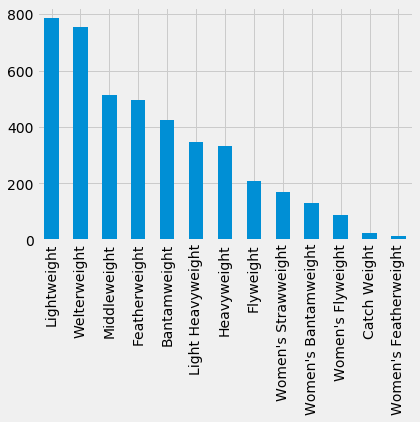

In [4]:
plt.style.use('fivethirtyeight')

data['weight_class'].value_counts().plot(kind="bar")

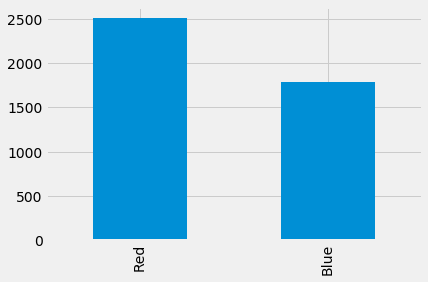

In [5]:
data['Winner'].value_counts().plot(kind="bar")

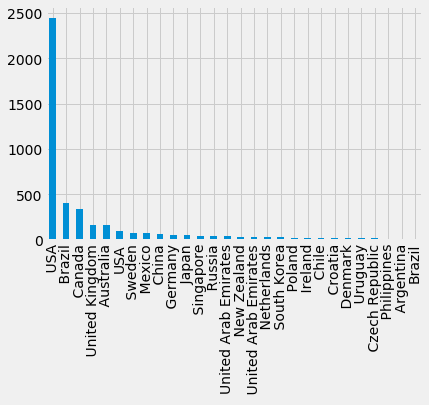

In [6]:
data['country'].value_counts().plot(kind="bar")

In [7]:
ufc_cut = pd.DataFrame.dropna(data, axis = 1, how = "any")

In [8]:
ufc_cut = ufc_cut[ufc_cut.B_Reach_cms != 0]

In [9]:
ufc_cut["Target"] = np.where(ufc_cut["Winner"].str.contains("Red"), 1, 0)

In [10]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = ufc_cut.corr()

<Figure size 864x720 with 0 Axes>

In [11]:
for col in cor.columns: 
    print(col) 

R_odds
B_odds
R_ev
B_ev
title_bout
no_of_rounds
B_current_lose_streak
B_current_win_streak
B_draw
B_longest_win_streak
B_losses
B_total_rounds_fought
B_total_title_bouts
B_win_by_Decision_Majority
B_win_by_Decision_Split
B_win_by_Decision_Unanimous
B_win_by_KO/TKO
B_win_by_Submission
B_win_by_TKO_Doctor_Stoppage
B_wins
B_Height_cms
B_Reach_cms
B_Weight_lbs
R_current_lose_streak
R_current_win_streak
R_draw
R_longest_win_streak
R_losses
R_total_rounds_fought
R_total_title_bouts
R_win_by_Decision_Majority
R_win_by_Decision_Split
R_win_by_Decision_Unanimous
R_win_by_KO/TKO
R_win_by_Submission
R_win_by_TKO_Doctor_Stoppage
R_wins
R_Height_cms
R_Reach_cms
R_Weight_lbs
R_age
B_age
lose_streak_dif
win_streak_dif
longest_win_streak_dif
win_dif
loss_dif
total_round_dif
total_title_bout_dif
ko_dif
sub_dif
height_dif
reach_dif
age_dif
sig_str_dif
avg_sub_att_dif
avg_td_dif
empty_arena
constant_1
Target


In [12]:
#Correlation with output variable
cor_target = abs(cor["Target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

R_odds     0.333623
B_odds     0.337662
R_ev       0.313217
B_ev       0.312062
R_age      0.107537
B_age      0.105494
age_dif    0.157110
Target     1.000000
Name: Target, dtype: float64

In [13]:
print(cor[["R_odds","R_ev"]].corr())

          R_odds      R_ev
R_odds  1.000000  0.979321
R_ev    0.979321  1.000000


In [15]:
ufc_cut_feat = ufc_cut[['R_odds', 'age_dif']]
ufc_cut_targ = ufc_cut['Winner']

In [16]:
seed = 50  # so that the result is reproducible
x_train, x_test, y_train, y_test = train_test_split(ufc_cut_feat, ufc_cut_targ , test_size = 0.2, random_state = seed)

In [17]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# Make predictions on test data
predictions = lr.predict(x_test)

In [19]:
# Use score method to get accuracy of model
score = lr.score(x_test, y_test)
print(score)

0.6623981373690337


In [20]:
cm = metrics.confusion_matrix(y_test, predictions)

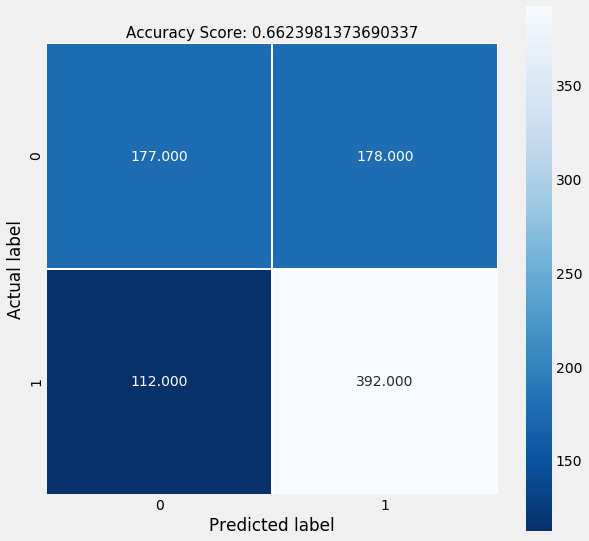

In [21]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);